In [1]:
########  TESTING BLOCK  ########
GLOBAL_TEST_FILE ="../parse_data/data/splited/1210.csv"
########  TESTING BLOCK  ########

In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

"""
把csv或excel檔案轉換成dataframe
以供後續的pandas操作
"""

import pandas as pd
import numpy as np
from datetime import datetime

def readStock_file(file, filetype='csv'):


    if filetype == 'excel':
        df = pd.read_excel(file, engine='openpyxl', parse_dates=True, header=None)
    else:
        df = pd.read_csv(file)

    # 取代原本的 column 名稱
    # 檔案的日期與開高低收需要照這個順序
    colume_name = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.columns = colume_name

    # 用日期這一行當做 df 的索引
    df = df.set_index('Date')

    # 把日期轉成 datetime的格式(從string)
    df.index = pd.to_datetime(df.index)

    # 照日期排序並把空資料轉成numpy的nan
    df = df.sort_index()
    df = df.replace(r'^\s*-$', np.nan, regex=True)


    for col in df.columns:
        if(col=='Date'):
            continue;
        df[col] = np.array([float(x) for x in df[col]])

    return df

def random_sample(ticker_list_file = "../parse_data/data/ticker_name.csv",  column = '證券代碼', times = 10):
    

    ticker_list_df = pd.read_csv(ticker_list_file, encoding='utf8', usecols=[column])
    ticker_list = ticker_list_df[column].to_list()
    
    sample = np.random.choice(ticker_list, times)
    sample_list = [i.replace(' ', '') for i in sample.tolist()]

    return sample_list

def file_list_with_directory(file_list, path):
    
    files = [path+i+'.csv' for i in file_list]
    return files

########  TESTING BLOCK  ########
lst = random_sample()
for i in file_list_with_directory(lst, '../parse_data/data/splited/'):
    print(i)
########  TESTING BLOCK  ########

../parse_data/data/splited/9910.csv
../parse_data/data/splited/2468.csv
../parse_data/data/splited/2107.csv
../parse_data/data/splited/8087.csv
../parse_data/data/splited/3114.csv
../parse_data/data/splited/4304.csv
../parse_data/data/splited/3588.csv
../parse_data/data/splited/1315.csv
../parse_data/data/splited/8422.csv
../parse_data/data/splited/4721.csv


In [3]:
class trade:

    
    """
    用於回測並模擬股票交易的模塊
    會在模擬交易時記錄價格並計算出投報率等數據
    
    建構式參數：
        ticker 是放了股價資料的 pandas dataframe
        comission 是手續費
        tax 是交易稅
        holding_limit 是持有股票上限
        print_trading 是否在result()時 印出交易資料
        print_returnRate 是否在result()時 印出投資報酬率
        print_tradingTimes 是否在result()時 印出交易次數

    成員變數：
        principal 股票購入金額
        balance 餘額
        holding_tickers 持有股票數量
        returns 投資報酬率
        trading_nums 交易次數
    """
    __comission = 0
    def __init__(self, ticker ,comission=0, tax=0, holding_limit=0,
                    print_trading=False, print_returnRate=False, print_tradingTimes=False):


        self.comission = comission
        self.tax = tax
        self.ticker = ticker
        self.holding_limit = holding_limit

        self.print_trading = print_trading
        self.print_returnRate = print_returnRate
        self.print_tradingTimes = print_tradingTimes

        self.principal = 0
        self.balance = 0
        self.holding_tickers = 0
        self.returns = 0
        self.trading_nums = 0

    """
    模擬買入股票
    這裡會印出買入的日期與價格

    操作流程：
        購入金額設為 含手續費的當日收盤價
        餘額減去 含手續費的當日收盤價
        股票持有數量加一
    """
    def buy(self):
        if((self.holding_limit == 0) or
            self.holding_tickers < self.holding_limit):

            if self.print_trading:
                date = datetime.strftime(self.date,'%Y/%m/%d')
                close_price = round(self.position['Close'],1)
                print('\t{} buy  {}'.format(date,close_price))

            
            self.principal += self.position['Close'] * (1 + self.comission)

            self.balance -= self.position['Close'] * (1 + self.comission)
            self.holding_tickers = self.holding_tickers + 1

        return None

    """
    模擬賣出股票
    這裡會印出賣出的日期與價格

    操作流程：
        購入金額設為 含手續費的當日收盤價
        餘額加回 含手續費與交易稅的當日收盤價
        股票持有數量減一
        交易次數加一(買入+賣出算一次)

        投報率算法：餘額 / 購入金額
        累計投報率：把所有投報率"加起來"
    """
    def sell(self):
        if(self.holding_tickers):
            if self.print_trading:
                date = datetime.strftime(self.date,'%Y/%m/%d')
                close_price = round(self.position['Close'] ,1)
                print('\t{} sell {}'.format(date,close_price))

            self.balance += self.position['Close'] * (1 - self.comission - self.tax) * self.holding_tickers

            self.returns += (self.balance/self.principal)
#             print(self.returns)
            self.principal, self.balance= 0,0
            self.holding_tickers = 0

            self.trading_nums = self.trading_nums+1
        return None

    """
    run()的時候，會在每一個日期逐一執行next
    實際在使用的時候需要複寫這個函式(用繼承的方式)
    否則會使用預設的next()

    預設：
        不論條件，每天買兩次賣一次
    """
    def next(self):

        self.buy()
        self.buy()
        self.sell()
        return None

    """
    在每一個日期逐一執行 next()
    而next()內會判斷是否需要在當天進行買入或賣出
    """
    def run(self):
        for index, row in self.ticker.iterrows():
            self.position = row
            self.date = index

            self.next()

        for _i in range(self.holding_tickers):
            self.sell()

    """
    返回投資報酬率
    並依照條件印出相關交易資料
    """
    def result(self):


        return_rate = round(self.returns *100, 4)

        if self.print_tradingTimes:
            print("\ttrading times : ", self.trading_nums)

        if self.print_returnRate:
            print("\treturn rate : {r}%".format(r=return_rate))

        return return_rate
    
########  TESTING BLOCK  ########
class derieved(trade):

    def next(self):
        if(self.position['buy'] == 1):
            self.buy()
        if(self.position['sell'] == 1):
            self.sell()

# 自己寫的 tools.readStock_file
ticker = readStock_file(GLOBAL_TEST_FILE)
ticker = ticker.head(600)

dw = pure_KD(ticker, plot=True,short_stop_loss=True)

# 手續費是0.1425%
# 股票交易稅是0.3%
# 持有上限是1
bakctesting = derieved(dw, 0.001425, 0.003, 0,
                print_trading=True,
                print_tradingTimes=True,
                print_returnRate=True)


bakctesting.run()

# result()會傳回投資報酬率
# 同時也會 print出交易記錄等資訊
result = bakctesting.result()
########  TESTING BLOCK  ########

NameError: name 'pure_KD' is not defined

In [11]:
"""
計算指標與信號常用的小工具
例如是否交叉，是否到達停損點等等
"""
import numpy as np

# 移動停損
# stop_loss 低於股價最高點多少比例就賣出
def moving_stop_loss(dw, stop_loss = 0.2):

    holding = 0 # 是否有持股
    high = 0 # 股票最高點

    # 如果沒有賣出信號這個欄位便新增
    if not 'sell' in dw:
        dw['sell'] = np.zeros(dw.shape[0])


    for index, row in dw.iterrows():
        if row['buy'] == 1:
            holding = 1


        # 持股時會持續記錄最高收盤價
        # 並判斷是否要賣出
        if holding:
            # 低於最高收盤價一定比例
            # 就產生賣出信號
            if row['Close'] < high*(1-stop_loss) :
                row['sell'] = 1

                holding = 0
                high = 0

            high = max(row['Close'], high)

    return dw

# 線a 是否在第 i 天向上穿出線b
def crossover(dw, i , a, b):
    if (((dw.iloc[i][a] > dw.iloc[i][b]) and
        (dw.iloc[i-1][a] < dw.iloc[i-1][b])) and
        (dw.iloc[i][a] > dw.iloc[i-1][a])):

        return 1;
def crossover_downward(dw, i, a, b):
    if (((dw.iloc[i][a] < dw.iloc[i][b]) and
        (dw.iloc[i-1][a] > dw.iloc[i-1][b])) and
        (dw.iloc[i][a] < dw.iloc[i-1][a])):

        return 1;

In [12]:
"""
這裡的函式可以用來計算指標
以價格動能相關的指標為主

dataframe裡，必須含有"Close"這個column
"""
import pandas as pd


def KD(ticker,RSVn = 9,RSVt = 3,Kt = 3,):
    tmp = pd.DataFrame(index=ticker.index)
    tmp['max_close'] = ticker['Close'].rolling(RSVn).max()
    tmp['min_close'] = ticker['Close'].rolling(RSVn).min()
    tmp['RSV'] = (ticker['Close'] - tmp['min_close'])/(tmp['max_close']-tmp['min_close'])*100

    tmp['k'] = tmp['RSV'].rolling(RSVt).mean()
    tmp['d'] = tmp['k'].rolling(Kt).mean()

    return tmp['k'], tmp['d']

def MA(ticker, interval = 20):
    return  ticker['Close'].rolling(interval).mean()

def RSI(ticker, interval = 6):
    tmp = pd.DataFrame(index=ticker.index)
    rise = ticker['Close'] - ticker['Open']
    drop = rise.copy()
    
    rise[rise < 0] = 0
    drop[drop > 0] = 0
    tmp['rise'] = rise
    tmp['drop'] = np.absolute(drop)

    tmp['rise_avg'] = tmp['rise'].rolling(interval).mean()
    tmp['drop_avg'] = tmp['drop'].rolling(interval).mean()

    tmp['rsa'] =  tmp['rise_avg'] / ( tmp['rise_avg'] + tmp['drop_avg']) * 100
    return tmp['rsa']

In [13]:
import mplfinance as mpf

MPF_COLORSET = mpf.make_marketcolors(up = 'r', down = 'g', volume = 'inherit')
MPF_STYLESET = mpf.make_mpf_style(marketcolors = MPF_COLORSET)
MPF_KWARGS = dict(type = 'candle', mav = 5, figscale = 2,\
              volume = True, volume_panel=2,
              style = MPF_STYLESET, scale_width_adjustment = dict(volume = 0.5))

def signal_points_generator(dw):
    buy, sell = [], []
    for index, row in dw.iterrows():
        buy.append(row['Close']*0.985 if row['buy'] else np.nan)
        sell.append(row['Close']*1.01 if row['sell'] else np.nan)
    return buy, sell

def all_nan(arr):
    if np.count_nonzero(np.isnan(arr)) == len(arr):
        return True
    return False

def plots_add_sell_buy(plots, points):
    buy_points, sell_points = points[0], points[1]
    # 如果有賣出的記錄就放進第一個 panel(main paenl)
    if not all_nan(sell_points):
        plots.append(mpf.make_addplot(sell_points , type = 'scatter', color = 'black', marker = 'v', markersize = 100))
    # 如果有買入的記錄就放進第一個 panel(main paenl)
    if not all_nan(buy_points):
        plots.append(mpf.make_addplot(buy_points , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

def init_sell_buy(ticker):
    dw = ticker
    dw['buy'] = np.zeros(dw.shape[0])
    dw['sell'] = np.zeros(dw.shape[0])
    return dw

../parse_data/data/splited/6496.csv
Date
2020-10-27          NaN
2020-10-28          NaN
2020-10-29          NaN
2020-10-30          NaN
2020-11-02          NaN
                ...    
2021-03-22    30.588235
2021-03-23    26.829268
2021-03-24    29.729730
2021-03-25    34.177215
2021-03-26    35.000000
Name: rsi, Length: 100, dtype: float64


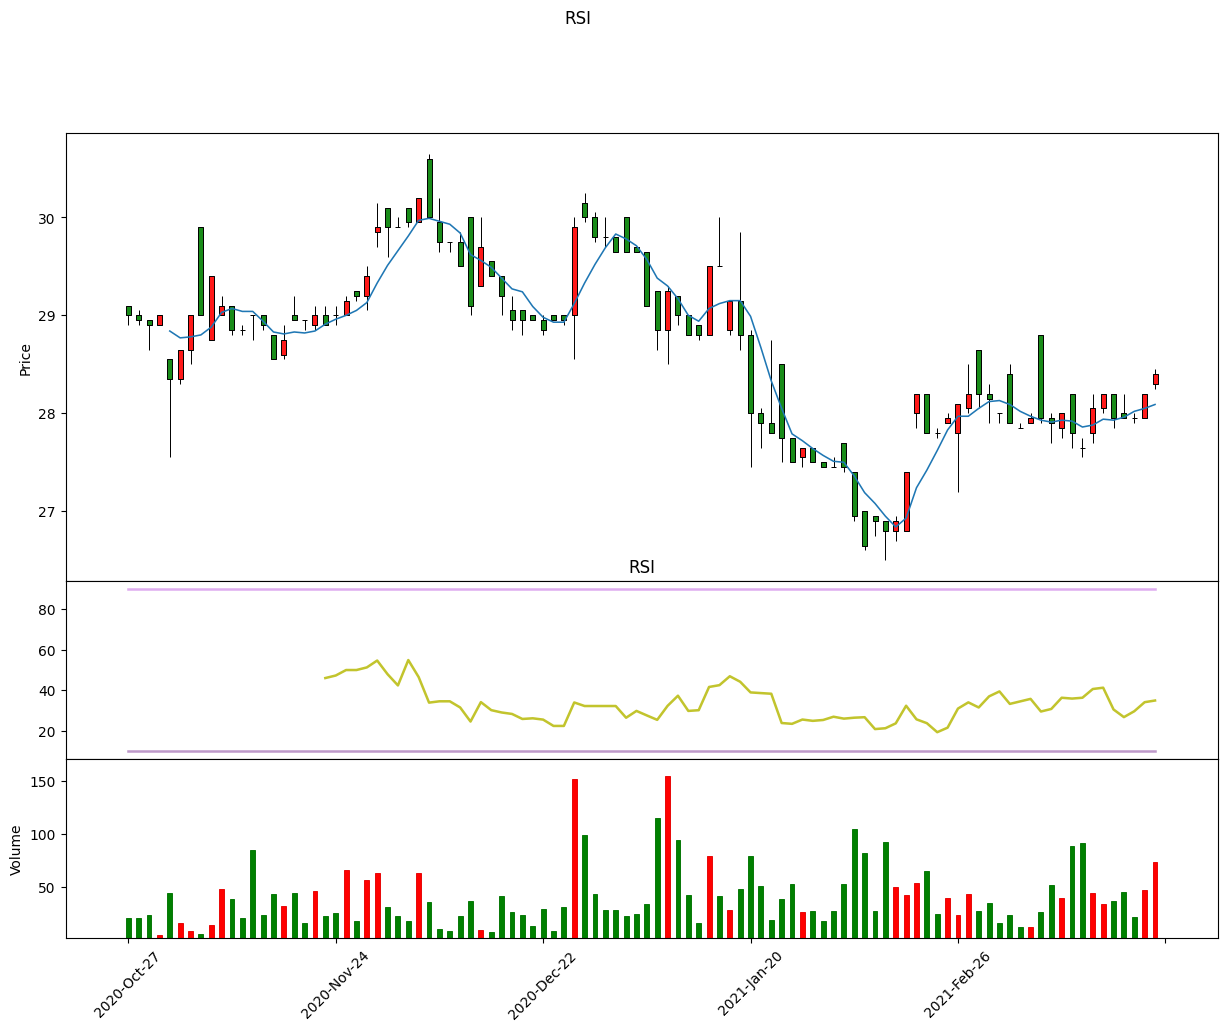

../parse_data/data/splited/2834.csv
Date
2020-10-27          NaN
2020-10-28          NaN
2020-10-29          NaN
2020-10-30          NaN
2020-11-02          NaN
                ...    
2021-03-22    53.846154
2021-03-23    52.631579
2021-03-24    50.000000
2021-03-25    50.781250
2021-03-26    49.193548
Name: rsi, Length: 100, dtype: float64


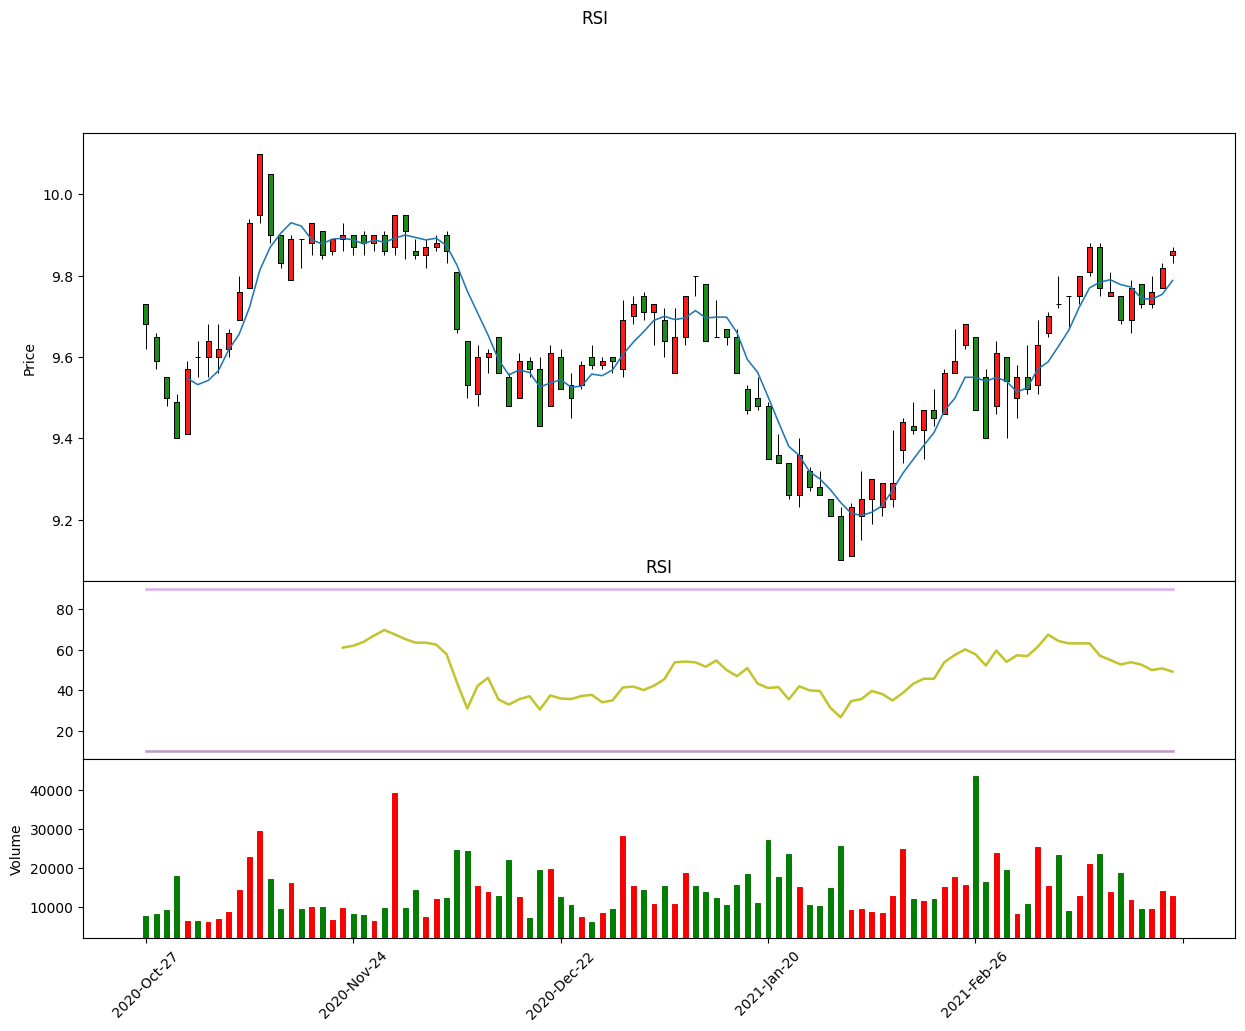

../parse_data/data/splited/5464.csv
Date
2020-10-27          NaN
2020-10-28          NaN
2020-10-29          NaN
2020-10-30          NaN
2020-11-02          NaN
                ...    
2021-03-22    61.052632
2021-03-23    53.608247
2021-03-24    55.000000
2021-03-25    54.545455
2021-03-26    52.000000
Name: rsi, Length: 100, dtype: float64


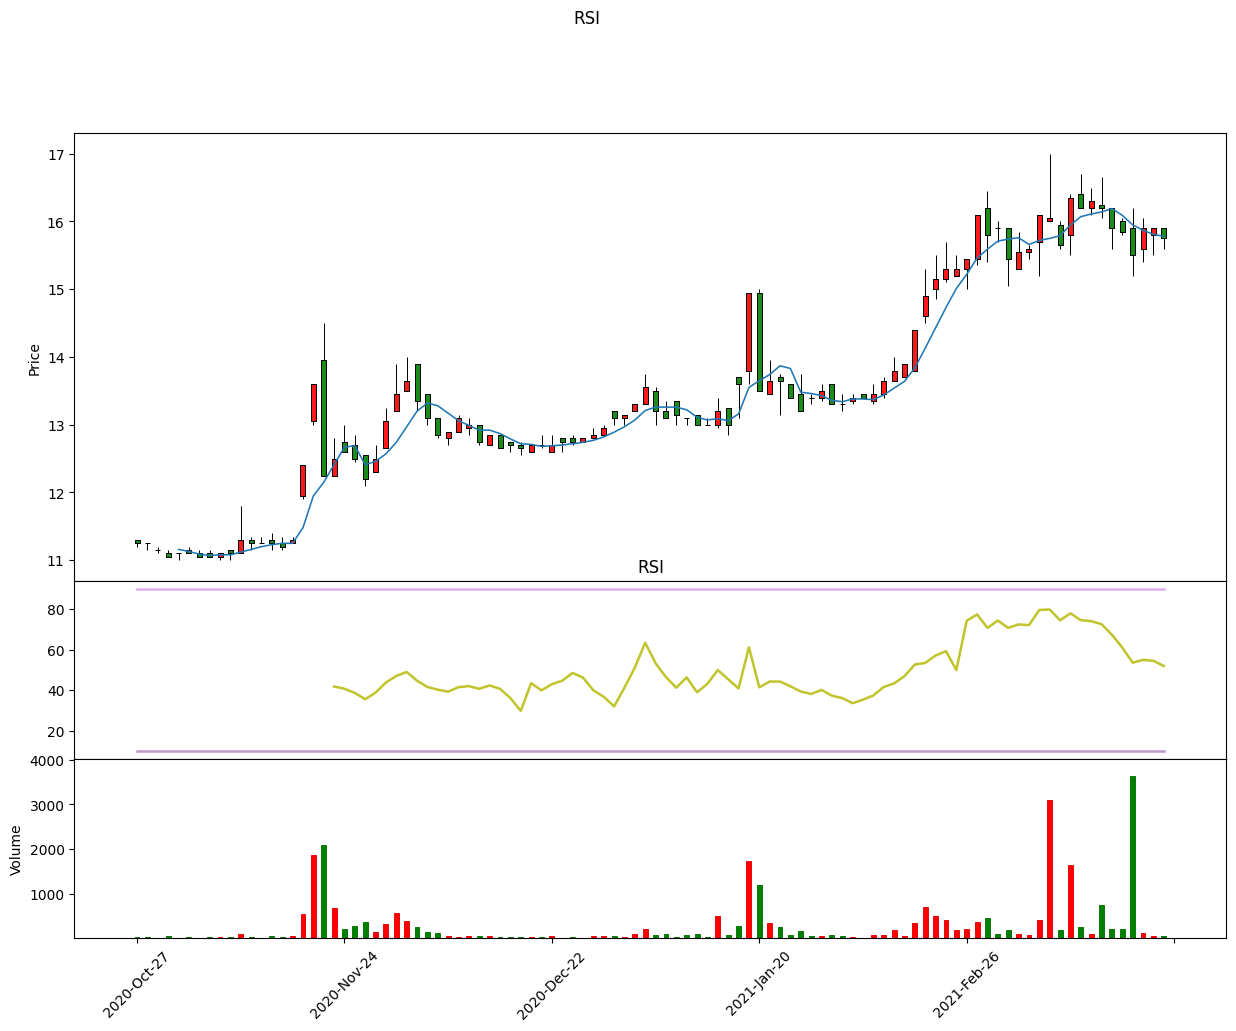

In [37]:
"""
放各種不同的股票策略
用上面的指標與是否停損等條件
判斷是否要買進賣出
"""
import pandas as pd
# import talib
import numpy as np
import mplfinance as mpf
from scipy.stats.mstats import gmean
stop_loss = 0.2
"""
只使用KD指標作為買入賣出的判斷
高點線以上黃金交叉就買入
地點線以下死亡交叉就賣出
參數：
    ticker 股價 dataframe
    RSVn RSV計算最高股價與最低股價取幾天為區間
    RSVt 計算K時，平滑RSV(移動平均) 取幾天為區間
    Kt 計算D時，平滑K(移動平均) 取幾天為區間
    upperBound KD高於這個點就買入
    lowerBound KD低於這個點就賣出
    short_stop_loss 移動停損率
"""
def pure_KD(ticker, RSVn = 9,
                        RSVt = 3,
                        Kt = 3,
                        upperBound = 70,
                        lowerBound = 30,
                        short_stop_loss=True,
                        plot=False):

    dw = ticker
    dw['slowk'], dw['slowd'] = KD(ticker, RSVn, RSVt, Kt)

    dw['signal'] = 0.0
    dw['signal'][RSVn:]  = np.where((dw['slowk'][RSVn:]
                                                > dw['slowd'][RSVn:]), 1.0, 0.0)

    # positon 是 1 便是 k 向上穿出 d
    #           -1則是 k 向下穿出 d
    # 這裡的黃金與死亡交叉定義比較寬鬆
    # 不限定 k或d 一定要往上或往下
    dw['positon'] = dw['signal'].diff()

    # k 向上穿出並大於高點線就買入
    dw['buy'] = np.where((dw['slowk'] > upperBound) & (dw['positon'] == 1 ), 1.0, 0.0)

    # 是否進行移動停損
    if short_stop_loss:
        dw = moving_stop_loss(dw, 0.2)
    else :

        # k 向下穿出並小於低點線就賣出
        dw['sell'] = np.where((dw['slowk'] < lowerBound) & (dw['positon'] == -1 ), 1.0, 0.0)

    
#     for index, row in dw.iterrows():
#         if(row['sell'] == 1):
#             print(row['Close'],row['slowk'],row['slowd'])
    if(plot):
        # 把 KD指標的圖放到第二個 panel 內
        plots = [
            # '#c2c42d' 是金色
            mpf.make_addplot(dw['slowk'], panel = 1, color='#c2c42d', title='K(yellow), D(blue)'),
            mpf.make_addplot(dw['slowd'], panel = 1, color='blue'),

            # upperbound 的線
            mpf.make_addplot(np.full((len(dw['slowk'])), upperBound), panel = 1, color='#bf5ce0', alpha=0.5),
            mpf.make_addplot(np.full((len(dw['slowk'])), lowerBound), panel = 1, color='#7e3696', alpha=0.5),
        ]

        plots_add_sell_buy( plots, signal_points_generator(dw))
        #繪圖 (股票資料、印出成交量、設定風格(蠟燭圖))
        mpf.plot(dw, **MPF_KWARGS, addplot = plots, title = 'KD Indicator')


    
    return dw

"""
僅用PPT內的MA線判斷，不加任何額外優化
減少注碼：
1. 酌量：股價往下跌破MA20 + 黑K線
2. 股價在MA20之下，且MA20有往下趨勢，可做空
	1. 水平向下彎
	2. 清倉：45度角往下
3. 股價加速向下，反彈至MA20，再向下彎

增加注碼：
1. 酌量：股價往上漲破MA20 + 紅K線
2. 股價在MA20之上，且MA20有往上趨勢
	1. 水平向上彎
	2. 45度角往上
3. 股價加速向上，反彈至MA20，再向上彎

參數：
    ticker 股價 dataframe
    ma_window 用幾日MA線當做判斷指標
"""
class basic_MA_simple:
    def __init__(self, ticker, ma_window=20):
        self.ticker = ticker
        self.window = ma_window
        
        self.ticker['ma'] = MA(ticker, interval=self.window)
        
        # MA線的成長率
        self.ma_rise_rate = []
        
        for i in range(ma_window): # 沒有MA線的前幾天填入np.nan
            self.ma_rise_rate.append(np.nan)

            
        # 計算MA線的成長率
        for i in range(ma_window, ticker.shape[0]):
            self.ticker['ma'] = MA(ticker, interval=self.window)
            cur = ticker['ma'][i]
            pre = ticker['ma'][i-1]
            rise = cur/pre
            self.ma_rise_rate.append(rise)
            
        
    """
    Prviate Member Function
    用在class內，判斷股價或指標的成長率是否處於上升狀態
    參數：
        dw 股價 dataframe
        rise_rate 指標或股價的成長率
        left_bound 區間的左側
        right_bound 區間的右側
        rise_rate_threshold 
            判斷成長的門檻
            在區間的成長率超過門檻
            就判斷成上升狀態
    """
    def __rise(self, dw, rise_rate, left_bound, right_bound, rise_rate_threshold = .004):
        
        lst = []
        
        for i in range(left_bound, right_bound+1):
            lst.append(rise_rate[i])
        
        threshold = 1 + rise_rate_threshold
        return (gmean(lst) > threshold)
    
    """
    Prviate Member Function
    只用在class內，判斷股價或指標的成長率是否處於下降狀態
    參數：
        dw 股價 dataframe
        drop_rate 指標或股價的成長率
        left_bound 區間的左側
        right_bound 區間的右側
        drop_rate_threshold 
            判斷成長的門檻
            在區間的成長率超過門檻
            就判斷成下降狀態
    """
    def __drop(self, dw, drop_rate, left_bound, right_bound, drop_rate_threshold = .004):
        
        lst = []
        for i in range(left_bound, right_bound+1):
            lst.append(drop_rate[i])
        
        threshold = 1 - drop_rate_threshold
        return (gmean(lst) < threshold)
    
    """
    Prviate Member Function
    只用在class內，判斷成長率是否處於平坦狀態
    參數：
        dw 股價 dataframe
        drop_rate 指標或股價的成長率
        left_bound 區間的左側
        right_bound 區間的右側
        flatten_rate_threshold 
            判斷平坦的門檻
            在區間的成長率在門檻內
            就判斷成平坦狀態
    """
    def __flatten(self, dw, left_bound, right_bound, flatten_rate_threshold = .0009):
        
        flat = True
        for i in range(left_bound, right_bound+1):
            if abs(1-self.ma_rise_rate[i]) > flatten_rate_threshold:
                flat = False
                break
        
        return flat
        
    def crossover_trade(self):
        
        # 把dataframe 加上sell和buy兩個columns
        # 並把初始化兩個columns
        dw = init_sell_buy(ticker)
        
        if dw.shape[0] > self.window:
            for i in range(self.window, dw.shape[0]-1):
                
            
                # 股價向上穿出MA20 && 紅K線
                if(crossover(dw, i, 'Close', 'ma') and (dw['Close'][i] > dw['Open'][i])):
                    dw['buy'][i] =  1

                # 股價向下穿出MA20 && 黑K線
                if( crossover_downward(dw, i+1, 'ma', 'Close') and (dw['Close'][i] < dw['Open'][i])):
                    dw['sell'][i] =  1
                    
        return dw
    
    def rise_from_horizontal(self, rise_flat_interval = 20):
                
        # 把dataframe 加上sell和buy兩個columns
        # 並把初始化兩個columns
        dw = init_sell_buy(ticker)
        
        # 確保股價的資料量比MA線的日數更多
        if dw.shape[0] > self.window:
            
            # 上一次平坦狀態距離現在幾天
            # 初始化為極大數(1*10^9)
            latest_flat = 1e9
            for i in range(self.window, dw.shape[0]-1):
                
                # 如果今天是平坦狀態，重設距離上次平坦的天數
                # 預設用前三天(i-3)到今天的狀態做判斷
                if(self.__flatten(dw, i-3, i)):
                    latest_flat = 0
                
                # 如果今天是成長狀態
                # 且距離上次平坦的天數在容許範圍(rise_flat_interval)內
                # 就判斷成買入
                # 預設用前五天(i-5)到今天的狀態做判斷
                if(self.__rise(dw,self.ma_rise_rate, i-5, i) and latest_flat < rise_flat_interval):
                    dw['buy'][i] = 1
                
                # 如果今天是下降狀態
                # 且距離上次平坦的天數在容許範圍(rise_flat_interval)內
                # 就判斷成賣出
                # 預設用前五天(i-5)到今天的狀態做判斷
                if(self.__drop(dw, self.ma_rise_rate, i-5, i) and latest_flat < rise_flat_interval):
                    dw['sell'][i] = 1
                
                latest_flat +=1 
        return dw
    def angle45(self):
        
                
        # 把dataframe 加上sell和buy兩個columns
        # 並把初始化兩個columns
        dw = init_sell_buy(ticker)
        
        # 確保股價的資料量比MA線的日數更多
        if dw.shape[0] > self.window:
            
            for i in range(self.window, dw.shape[0]-1):
                
                # 一樣是判斷成上升
                # 但是這裡的門檻(rise_rate_threshold)更高
                # 需要有更高的成長率才會判斷成 MA線 > 45度
                # 這裡的 > 45度 不是嚴謹的計算角度
                # 而是成長率大於一定值就判斷成角度夠大
                if self.__rise(dw,self.ma_rise_rate, i-5, i, rise_rate_threshold=0.006):
                    dw['buy'][i] = 1
                
                # 判斷成下降，其他同上
                if self.__drop(dw, self.ma_rise_rate, i-5, i, drop_rate_threshold=0.008):
                    dw['sell'][i] = 1
        return dw
    
    """
    股價加速上升，反彈至MA20後，股價再往上
    """
    def rise_bound(self, rise_drop_interval=10, bound_interval=5):
        
        # 把dataframe 加上sell和buy兩個columns
        # 並把初始化兩個columns
        dw = init_sell_buy(ticker)
        
        # 確保股價的資料量比MA線的日數更多
        if (dw.shape[0] > self.window and self.window > 5):
            
            # 計算股價的上升率
            price_rise_rate = []
            for i in range(dw.shape[0]):
                price_rise_rate.append(dw['Close'][i] / dw['Open'][i])
                
            # 上次股價上升，並下降碰觸到MA線距離現在幾天
            bounded_buy = 1e9
            
            # 上次股價下降，並上升碰觸到MA線距離現在幾天
            bounded_sell = 1e9

            # 上一次上升(rise)/下降(drop)狀態距離現在幾天
            # 初始化為極大數(1*10^9)
            latest_rise = 1e9
            latest_drop = 1e9

            # 確保股價的資料量比MA線的日數更多
            for i in range(self.window, dw.shape[0]-1):
                
                # 處於上升狀態且股價大於MA線
                if(self.__rise(dw, price_rise_rate, i-5, i) and dw['Close'][i] > dw['ma'][i]):
                    
                    # 重設上一次股價上升的日數
                    latest_rise = 0
                    
                    # 如果 股價已經上升且在近期反彈至MA線過
                    # 現在又再次上升，買入
                    if bounded_buy <= bound_interval:
                        bounded_buy = 1e9
                        dw['buy'][i] = 1
                        
                # 處於下降狀態且股價小於MA線
                if(self.__drop(dw, price_rise_rate, i-5, i) and dw['Close'][i] < dw['ma'][i]):
                    
                    # 重設上一次股價下降的日數
                    latest_drop = 0
                    
                    # 如果 股價已經下降且在近期反彈至MA線過
                    # 現在又再次下降，買入
                    if bounded_sell <= bound_interval:
                        bounded_sell = 1e9
                        dw['sell'][i] = 1
                
                # 最近股價有判斷成上升狀態，且股價又降到MA線之下
                # 就把重設上次反彈(bounded_buy)的天數
                if(dw['Close'][i] <= dw['ma'][i] and latest_rise <= rise_drop_interval):
                    bounded_buy = 0
                    
                # 最近股價有判斷成上升狀態，且股價又降到MA線之下
                # 就把重設上次反彈(bounded_sell)的天數
                if(dw['Close'][i] >= dw['ma'][i] and latest_drop <= rise_drop_interval):
                    bounded_sell = 0
                    
                latest_rise += 1
                latest_drop += 1
                bounded_sell += 1
                bounded_buy += 1
                
                    
        return dw
        
    def plot(self, dw):
        plots = []
        plots_add_sell_buy( plots, signal_points_generator(dw))
        #繪圖 (股票資料、印出成交量、設定風格(蠟燭圖))
        AVG_KWARGS = dict(type = 'candle', 
                          mav = self.window , 
                          figscale = 2,
                          volume = True,
                          style = MPF_STYLESET, 
                          scale_width_adjustment = dict(volume = 0.75))
        mpf.plot(dw, **AVG_KWARGS, addplot = plots, title = 'Basic Moving Average')
       
"""

"""
class basic_RSI:
    def __init__(self, ticker, rsa_n=20):
        self.ticker = ticker
        self.rsa_n = rsa_n
        
        self.ticker['rsi'] = RSI(ticker, interval = rsa_n)
        print(self.ticker['rsi'])
        
        self.args = []
        
    """
    RSI超過上界(upperbound)就買入
    RSI低於下界(lowerbound)就賣出
    參數：
        upperbound 判斷買入的門檻
        lowerbound 判斷賣出的門檻
    """
    def bound_only(self, upperbound = 90, lowerbound=10):
        dw = init_sell_buy(self.ticker)
        self.args = [upperbound, lowerbound]
        

        for i in range(self.rsa_n, dw.shape[0]-1):
            if(dw['rsi'][i] >= upperbound):
                dw['buy'][i] = 1
            if(dw['rsi'][i] <= lowerbound ):
                dw['sell'][i] = 1
        return dw
    
    
    def plot(self, dw):
                
        plots = [
            # '#c2c42d' 是金色
            mpf.make_addplot(self.ticker['rsi'], panel = 1, color='#c2c42d', title='RSI'),
        ]
        if(self.args):
            plots += [
            # upperbound 的線
            mpf.make_addplot(np.full((len(dw['rsi'])), self.args[0]), panel = 1, color='#bf5ce0',secondary_y=False, alpha=0.5),
            # lowerbound 的線
            mpf.make_addplot(np.full((len(dw['rsi'])), self.args[1]), panel = 1, color='#7e3696',secondary_y=False, alpha=0.5),
            ]

        plots_add_sell_buy( plots, signal_points_generator(dw))
        #繪圖 (股票資料、印出成交量、設定風格(蠟燭圖))
        mpf.plot(dw, **MPF_KWARGS, addplot = plots, title = 'RSI')

"""
使用三條均線進行判斷
產生金三角就買入
賣出則只使用移動停損
參數：
    ticker 股價 dataframe
    ma_window_short 第一條均線的區間
    ma_window_mid   第二條均線的區間
    ma_window_long  第三條均線的區間
    tolerence_interval  金三角的容許範圍
"""
def tripleMA_stopLoss(  ticker,
                ma_window_short = 7,
                ma_window_mid = 15,
                ma_window_long = 21,
                tolerence_interval = 7,
                plot = False):

    dw = ticker

    # 計算三條平均線
    dw['ma_short'] = MA(dw, ma_window_short)
    dw['ma_mid'] = MA(dw, ma_window_mid)
    dw['ma_long'] = MA(dw, ma_window_long)
    
    
    # 初始化 買入信號的欄位
    dw['buy'] = np.zeros(dw.shape[0])
    if dw.shape[0] > ma_window_long:

        # 上一次 短線向上穿出中線 距離現在幾天
        last_cross_mid = tolerence_interval
        # 上一次 短線向上穿出長線 距離現在幾天
        last_cross_long = tolerence_interval
        for i in range(ma_window_long, dw.shape[0]):

            if crossover(dw, i, 'ma_short', 'ma_mid'):
                last_cross_mid = 0
            if crossover(dw, i, 'ma_short', 'ma_long'):
                last_cross_long = 0

            # 容許範圍內，短線是否向上穿出中線，短線是否向上穿出長線
            # 如果都有，且中線也向上穿出長線
            # 就判斷為金三角
            if (crossover(dw, i, 'ma_mid', 'ma_long') and
                last_cross_mid < tolerence_interval and
                last_cross_long < tolerence_interval) :

                # 金三角買入
                dw['buy'][i] =  1

                # 重置上一次短線穿出 距離現在幾天
                last_cross_mid = tolerence_interval
                last_cross_long = tolerence_interval

            last_cross_mid = last_cross_mid+1
            last_cross_long = last_cross_long+1

    # 賣出信號 僅使用移動停損
    dw = moving_stop_loss(dw, 0.2)
    
    if plot:
        plots = []
        plots_add_sell_buy( plots, signal_points_generator(dw))
        #繪圖 (股票資料、印出成交量、設定風格(蠟燭圖))
        AVG_KWARGS = dict(type = 'candle', 
                          mav = (ma_window_short,ma_window_mid,ma_window_long) , 
                          figscale = 2,
                          volume = True,
                          style = MPF_STYLESET, 
                          scale_width_adjustment = dict(volume = 0.75))
        mpf.plot(dw, **AVG_KWARGS, addplot = plots, title = 'Moving Average Golden Triangle')
    return dw

"""
使用威廉指標進行判斷
會先判斷股價是否是近期最高點
如果是的話，低於低點線會買入
如果不是的話，高於高點線賣出
參數：
    ticker 股價 dataframe
    n 威廉指標的計算區間
    tolerence_interval 近期最高點的判斷天數
    lowerBound 低點線
    upperBound 高點線
    short_stop_loss 移動停損率
"""
def WMR(ticker, n = 14, tolerence_interval = 4, upperBound = 80, lowerBound = 20, short_stop_loss = True):
    dw = ticker

    # n 天內最高收盤價
    dw['current_high'] = dw['Close'].rolling(n).max()
    # n 天內最低收盤價
    dw['current_low'] = dw['Close'].rolling(n).min()

    # 威廉指標
    dw['W%R'] = (dw['current_high'] - dw['Close'])/(dw['current_high']-dw['current_low'])*100

    # tolerence_interval 期間內最高收盤價
    dw['HIGH_current_high'] =  dw['High'].rolling(tolerence_interval).max()

    # 是近期最高，且低於地點線，買入
    dw['buy'] = np.where((dw['W%R'] < lowerBound) & (dw['High'] == dw['HIGH_current_high'] ), 1.0, 0.0)

    # 是否進行移動停損
    if short_stop_loss:
        dw = moving_stop_loss(dw, 0.2)
    else :

        # 不是近期最高，且高於高點線，賣出
        dw['sell'] = np.where((dw['W%R'] > upperBound) & (dw['High'] != dw['HIGH_current_high']  ), 1.0, 0.0)


    return dw

########  TESTING BLOCK  ########
random_choice_num = 3
data_directory = '../parse_data/data/splited/'
for data_file in file_list_with_directory(random_sample(times = random_choice_num), data_directory):
    print(data_file)
    ticker = readStock_file(data_file)
    ticker = ticker.tail(100)
    
    strategy = basic_RSI(ticker)
    signals = strategy.bound_only()
    strategy.plot(signals)
########  TESTING BLOCK  ########

In [7]:
"""
main()的部分
把上面的所有東西統合起來
用模擬交易去跑上述的策略
"""
import pandas as pd
import numpy as np
import glob
from functools import partial

########  Basic Settings  ########
print_format = {'tradingRecord'     : False, # 交易記錄
                'tradingNum'        : True,# 交易次數
                'fileName'          : True, # 逐一顯示檔案名稱
                'fileNameNewLine'   : True, # 每一個檔案跑完是否加換行
                'returnRate'        : True, # 投資報酬率
                }

# 用正則表示式表示有哪些檔案
file_pattern = "../parse_data/data/splited/1210.csv"
data_directory = '../parse_data/data/splited/'
random_choice_num = 10
limit_time_interval = 600

# 選取下列策略中的哪一個
choose_strategy = 'basic_MA'
########  Basic Settings  ########

########  Strategiy Configuration  ########

# 用functools.partial()把function的參數儲存起來
# 之後呼叫就不需要再傳入重複的參數
strategies = {
    'WMR' : partial(
        WMR,
        short_stop_loss=True,),      # 移動停損

    'Complete_KD' : partial(
        pure_KD,
        short_stop_loss=True,),       # 移動停損

    'tripleMA_stopLoss' : partial(
        tripleMA_stopLoss,
        ma_window_short = 7,        # 第一條均線的區間
        ma_window_mid = 15,         # 第二條均線的區間
        ma_window_long = 21,        # 第三條均線的區間
        tolerence_interval = 7),    # 金三角的容許範圍
    
    'basic_MA' : partial(
        basic_MA,
        ma_window = 20,
        plot=False),
}
########  Strategiy Configuration  ########

# 在新的 class中表示出什麼時候買
# 例如 當self.position的買入信號是1的時候買
class derieved(trade):

    def next(self):
        if(self.position['buy'] == 1):
            self.buy()
        if(self.position['sell'] == 1):
            self.sell()


returnRates = {}
# for data_file in glob.glob(file_pattern):
for data_file in file_list_with_directory(random_sample(times = random_choice_num), data_directory):

    if print_format['fileName']:
        print(data_file, end='\n' if print_format['fileNameNewLine'] else '')

    # 自己寫的 tools.readStock_file
    ticker = readStock_file(data_file)
    if limit_time_interval:
        ticker = ticker.head(limit_time_interval)
    
    dw = strategies[choose_strategy](ticker)

    # 手續費是0.1425%
    # 股票交易稅是0.3%
    # 持有上限是1
    bakctesting = derieved(dw, 0.001425, 0.003, 0,
                    print_trading=print_format['tradingRecord'],
                    print_tradingTimes=print_format['tradingNum'],
                    print_returnRate=print_format['returnRate'])


    bakctesting.run()

    # result()會傳回投資報酬率
    # 同時也會 print出交易記錄等資訊
    result = bakctesting.result()

    # 如果投報率非 None
    # 便存入 returnRates 這個dictionary
    if result:
        returnRates[data_file] = result

# 把 returnRates 內所有的投報率轉換成 numpy 陣列
returnRates_arr = np.fromiter(returnRates.values(), dtype=float)
# 用 numpy 加總
final_return_rate = round(returnRates_arr.sum(), 4)

print("\nFinal total return rate : {}%".format(final_return_rate))

# 依照 投報率 進行排序，由高到低
returnRates = dict(sorted(returnRates.items(), key=lambda item: item[1], reverse=True))
print("Highest 4 return rate :")

# 列出 top3 的投報率
counter = 0
for key, value in returnRates.items():
    print("\t\"{}\" return rate : {}%".format(key, value))
    counter = counter+1
    if counter == 4:
        break;

        

NameError: name 'WMR' is not defined